In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [133]:
# Sean's pathname
pathname = '/Users/seantsung/Library/CloudStorage/Box-Box/Stanford CPET Projects/'
df = pd.read_parquet(pathname + 'BBB DATA/CPX datasets-selected/CleanedDatasets/combined_outcome_df.parquet')

In [135]:
# Yuewei's pathname
# pathname = '/Users/yueweiling/Documents/Data/cpet-ai/'
pathname = 'E:/Python/Data/cpet-ai/'
df = pd.read_parquet(pathname + 'combined_outcome_df.parquet')

#### Data preprocessing

In [136]:
# column names
for column_name in df.columns:
    print(column_name)

ID1
testDate
testTime
testDateTime
MRN
DOB
Height
AmbientTemp
Weight
TestDuration
AmbientRH
ExerciseDuration
firstName
lastName
Gender
Ergometer
Protocol
BarometricPress
Time
Rf
VT
VE
VO2
VCO2
RQ
O2exp
CO2exp
VE/VO2
VE/VCO2
VO2/Kg
METS
HR
VO2/HR
FeO2
FeCO2
FetO2
FetCO2
FiO2
FiCO2
SpO2
Power
Real_Power
Revolution
Speed
Grade
P_Syst
P_Diast
Phase
Ambient_Temp
RH_Amb
Analyzer_Pressure
PB
Ti
Te
Dyspnea
Leg Pain
ID
MRN-test date
Death
death_date
death_yrs
pre_arrhythm_surg
pre_arrhythm_surg_date
pre_arrhythm_surg_yrs
pre_card_surg
pre_card_surg_date
pre_card_surg_yrs
pre_acute_coronary_syndrome
pre_acute_coronary_syndrome_date
pre_acute_coronary_syndrome_yrs
pre_acute_heart_failure
pre_acute_heart_failure_date
pre_acute_heart_failure_yrs
pre_acute_respiratory_failure
pre_acute_respiratory_failure_date
pre_acute_respiratory_failure_yrs
pre_afib_flut
pre_afib_flut_date
pre_afib_flut_yrs
pre_cardiac_arrest
pre_cardiac_arrest_date
pre_cardiac_arrest_yrs
pre_cardiogenic_shock
pre_cardiogenic_sho

In [137]:
# Age
df['Age'] = (df['testDateTime'] - df['DOB']).dt.days / 365

In [138]:
# Difference between 'TestDuration' and 'Max_Time'
df['Max_Time'] = df['Time'].apply(max)
df['TestDurationTimeMaxDifference'] = abs(df['TestDuration'] - df['Max_Time'])
df['TestDurationTimeMaxDifference'].describe()

count    2089.000000
mean        4.111058
std         4.627206
min         0.000000
25%         0.000000
50%         3.000000
75%         7.000000
max        33.000000
Name: TestDurationTimeMaxDifference, dtype: float64

**Time-series data preprocessing**

In [139]:
time_series_columns = ['Time', 'Rf', 'VT', 'VE', 'VO2', 'VCO2', 'RQ', 'O2exp', 'CO2exp', 'VE/VO2', 'VE/VCO2', 'VO2/Kg', 'METS', 'HR', 'VO2/HR', 'FeO2', 'FeCO2', 'FetO2', 'FetCO2', 'FiO2', 'FiCO2', 'SpO2', 'Power', 'Real_Power', 'Revolution', 'Speed', 'Grade', 'P_Syst', 'P_Diast', 'Phase', 'Ambient_Temp', 'RH_Amb', 'Analyzer_Pressure', 'PB', 'Ti', 'Te', 'Dyspnea', 'Leg Pain']

In [140]:
def filter_time_series_columns(df, time_series_columns, skip_column, nan_threshold, empty_list_threshold):
    df_filtered = df.copy()

    for col in time_series_columns:
        if col == skip_column:
            continue
        
        # Replace arrays with an empty array if the proportion of NaN values exceeds nan_threshold
        df_filtered[col] = df_filtered[col].apply(
            lambda x: np.array([]) if pd.isna(x).mean() > nan_threshold else x
        )

        # Drop columns if the proportion of empty array exceeds empty_list_threshold
        empty_array_count = df_filtered[col].apply(lambda x: isinstance(x, np.ndarray) and x.size == 0).sum()
        total_array_count = len(df_filtered[col])
        missing_array_proportion = empty_array_count / len(df_filtered[col])
        if missing_array_proportion > 0:
            print(f"Column {col} contains {missing_array_proportion*100:.1f}% empty arrays.")
            if missing_array_proportion > empty_list_threshold:
                df_filtered.drop(columns=[col], inplace=True)

    return df_filtered

In [141]:
df_filtered = filter_time_series_columns(df, time_series_columns, skip_column='Time', nan_threshold=0.10, empty_list_threshold=0.10)

Column HR contains 0.4% empty arrays.
Column VO2/HR contains 0.4% empty arrays.
Column Power contains 87.0% empty arrays.
Column Real_Power contains 88.8% empty arrays.
Column Revolution contains 88.8% empty arrays.
Column Speed contains 13.2% empty arrays.
Column Grade contains 13.2% empty arrays.
Column P_Syst contains 86.5% empty arrays.
Column P_Diast contains 86.5% empty arrays.
Column RH_Amb contains 13.2% empty arrays.
Column Dyspnea contains 86.8% empty arrays.
Column Leg Pain contains 100.0% empty arrays.


In [142]:
filtered_time_series_columns = [col for col in time_series_columns if col in df_filtered.columns
                               and col != 'Phase']

In [143]:
def calculate_statistics_for_columns(df, time_series_columns, skip_column):
    stats_df = df.copy()
    stats_column_names = []
    
    for col in time_series_columns:
        if col == skip_column:
            continue
            
        stats_df[f"{col}_min"] = stats_df[col].apply(lambda x: np.nanmin(x) if x.size != 0 else np.nan)
        #stats_df[f"{col}_Q1"] = stats_df[col].apply(lambda x: np.nanquantile(x, 0.25) if x.size != 0 else np.nan)
        #stats_df[f"{col}_median"] = stats_df[col].apply(lambda x: np.nanquantile(x, 0.50) if x.size != 0 else np.nan)
        #stats_df[f"{col}_Q3"] = stats_df[col].apply(lambda x: np.nanquantile(x, 0.75) if x.size != 0 else np.nan)
        stats_df[f"{col}_max"] = stats_df[col].apply(lambda x: np.nanmax(x) if x.size != 0 else np.nan)
        stats_df[f"{col}_mean"] = stats_df[col].apply(lambda x: np.nanmean(x) if x.size != 0 else np.nan)
        stats_df[f"{col}_std"] = stats_df[col].apply(lambda x: np.nanstd(x) if x.size != 0 else np.nan)
        # stats_column_names.extend([f"{col}_min", f"{col}_Q1", f"{col}_median", f"{col}_Q3", f"{col}_max", f"{col}_mean", f"{col}_std"])        # stats_column_names.extend([f"{col}_min", f"{col}_Q1", f"{col}_median", f"{col}_Q3", f"{col}_max", f"{col}_mean", f"{col}_std"])
        stats_column_names.extend([f"{col}_min", f"{col}_max", f"{col}_mean", f"{col}_std"])
        stats_df.drop(columns=[col], inplace=True)
        
    return stats_df, stats_column_names

In [144]:
stats_df, stats_column_names = calculate_statistics_for_columns(df_filtered, filtered_time_series_columns, skip_column='Time')

#### Exploratory data analysis

In [145]:
outcome_columns = ['Death', 'composite_outcome']
feature_columns = stats_column_names + ['Gender', 'Age', 'Height', 'Weight', 'TestDuration', 'ExerciseDuration', 'BarometricPress', 'AmbientTemp', 'AmbientRH']

In [146]:
selected_df = stats_df[outcome_columns + feature_columns]

In [147]:
# Number of rows with at least one missing value
(selected_df.isnull().sum(axis=1) > 0).sum()

8

In [148]:
selected_df.isnull().sum().sort_values(ascending=False).head(20)

VO2/HR_std     8
VO2/HR_max     8
HR_min         8
HR_max         8
HR_std         8
VO2/HR_min     8
HR_mean        8
VO2/HR_mean    8
FiCO2_mean     0
FetCO2_std     0
FiCO2_std      0
SpO2_min       0
FiCO2_max      0
FiCO2_min      0
FiO2_std       0
FiO2_mean      0
FiO2_max       0
FiO2_min       0
FetO2_std      0
FetCO2_mean    0
dtype: int64

In [149]:
data = selected_df.dropna(axis=0, how='any')

In [150]:
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

In [151]:
data['BarometricPress'] = data.BarometricPress.astype(int)

In [152]:
categorical_columns = ['Death', 'composite_outcome', 'Gender']
numerical_columns = [col for col in data.columns if col not in categorical_columns]

**Correlation heatmap**

In [153]:
corr_numerical_columns = ['VO2/Kg_std', 'HR_max', 'VO2/Kg_max', 'Age']

In [154]:
# Pearson correlation for numerical features
numerical_corr = data[corr_numerical_columns].corr(method='pearson')

In [155]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = stats.chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

In [156]:
# Cramér's V for categorical features
categorical_corr = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        categorical_corr.loc[col1, col2] = cramers_v(data[col1], data[col2])

In [157]:
# Point-Biserial Correlation for categorical-numerical Columns
categorical_numerical_corr = pd.DataFrame(index=categorical_columns, columns=corr_numerical_columns)
for cat_col in categorical_columns:
    for num_col in corr_numerical_columns:
        categorical_numerical_corr.loc[cat_col, num_col] = pointbiserialr(data[cat_col], data[num_col])[0]

In [158]:
full_corr_matrix = pd.concat([
    pd.concat([categorical_corr, categorical_numerical_corr.T], axis=0),
    pd.concat([numerical_corr, categorical_numerical_corr], axis=0)
], axis=1).fillna(0).round(1)

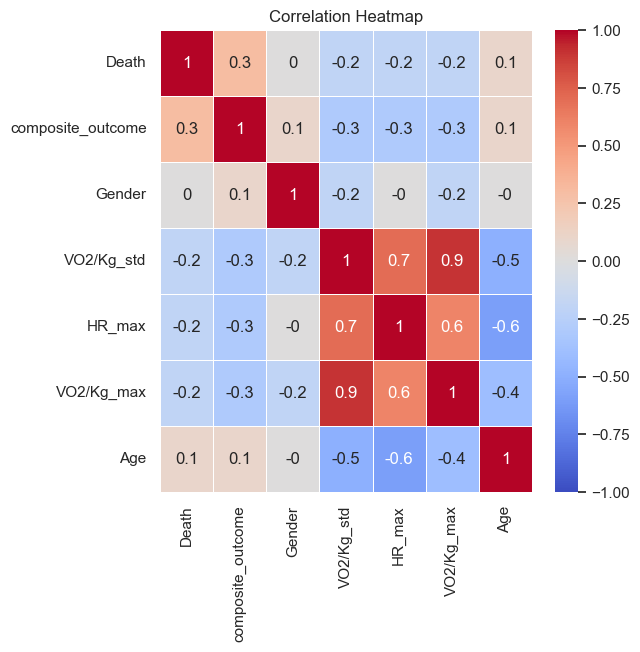

In [159]:
plt.figure(figsize=(6, 6))
sns.heatmap(full_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, center=0, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

**Frequency distribution**

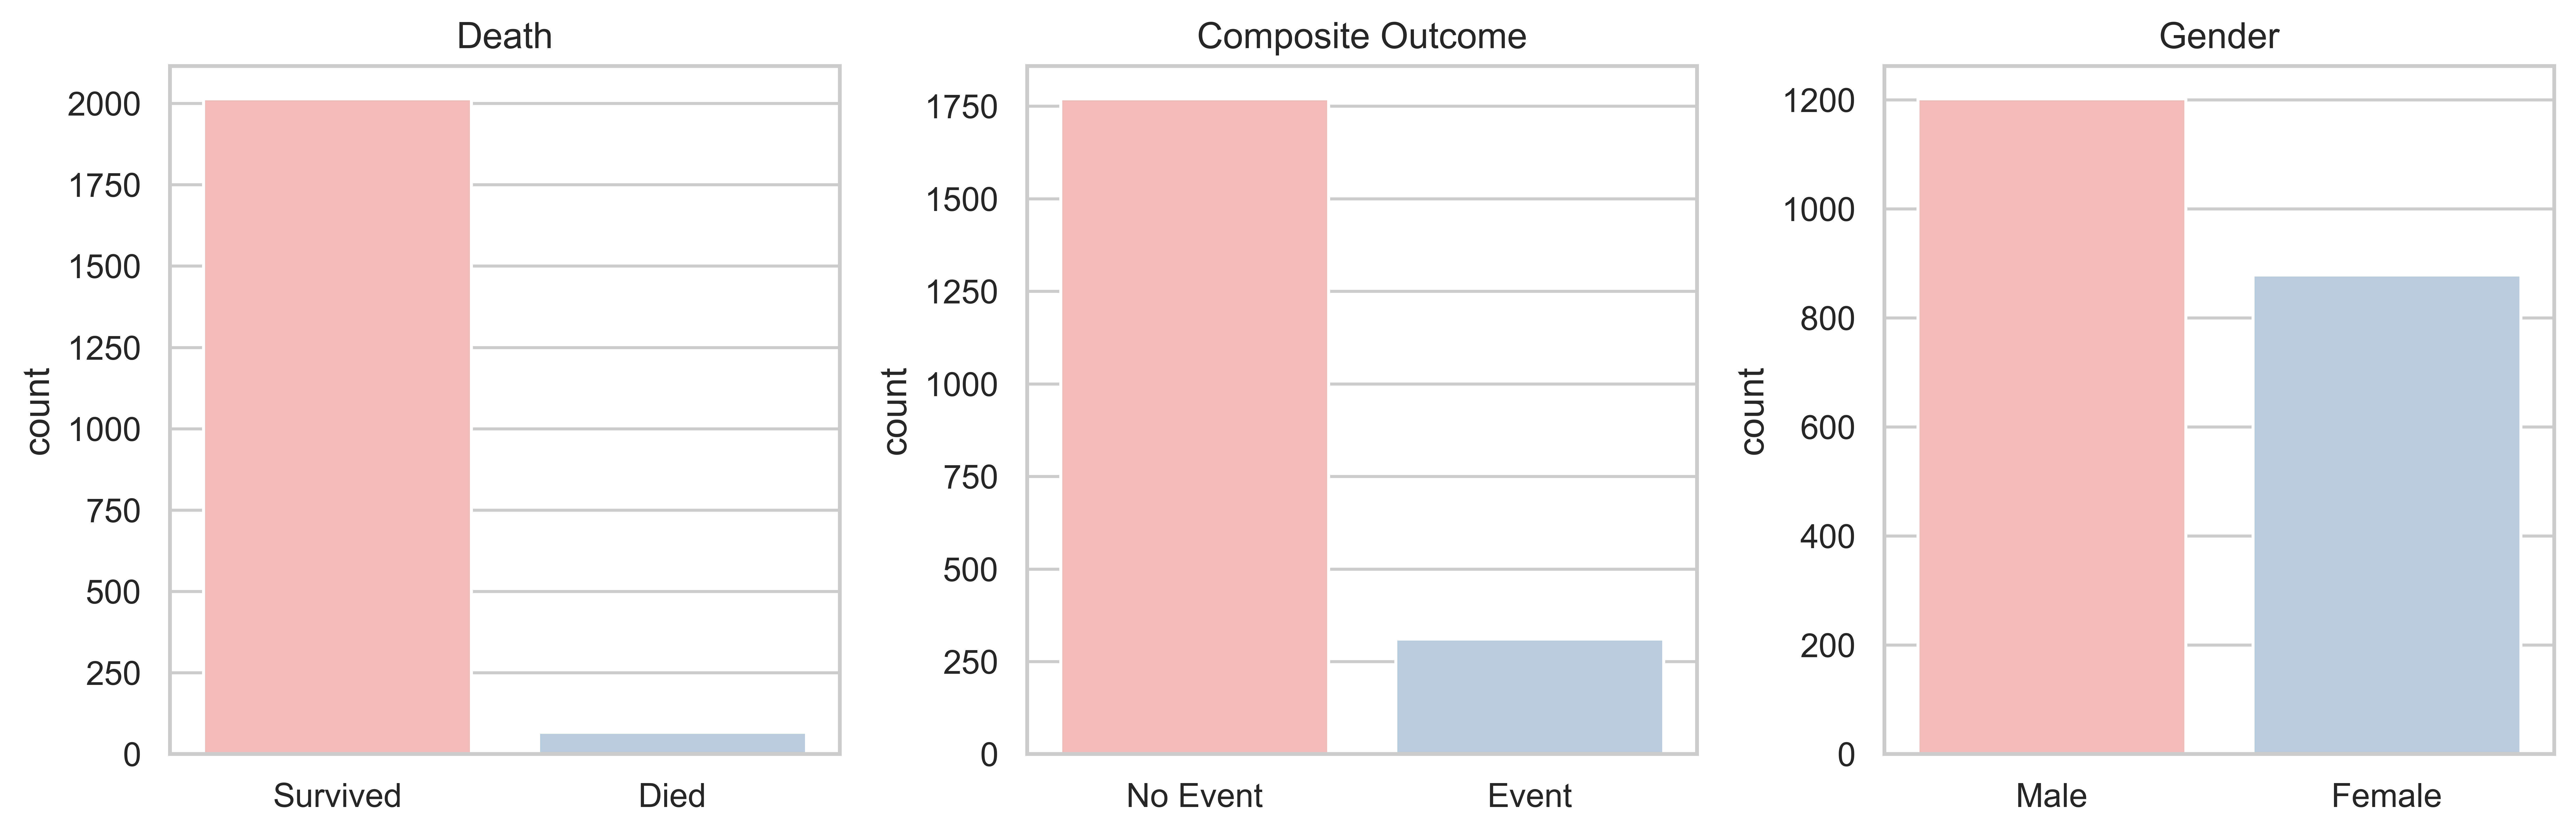

In [160]:
cat_data = data.copy()
cat_data['Death'] = cat_data['Death'].map({1: 'Died', 0: 'Survived'})
cat_data['composite_outcome'] = cat_data['composite_outcome'].map({0: 'No Event', 1: 'Event'})
cat_data['Gender'] = cat_data['Gender'].map({0: 'Male', 1: 'Female'})

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=800)
ax_title_pairs_categorical = zip(axs.flat, categorical_columns)
for ax, title in ax_title_pairs_categorical:
    sns.countplot(x=title, data=cat_data, palette='Pastel1', ax=ax)
    if title == "composite_outcome":
        ax.set_title("Composite Outcome")
    else:
        ax.set_title(title)
    ax.set_xlabel('')
plt.tight_layout()

In [161]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=800)
data_grouped = data.groupby(by='Death')
selected_numerical_columns = ['VO2/Kg_std', 'HR_max', 'VO2/Kg_max', 'Age']
ax_title_pairs_numerical = zip(axs.flat, selected_numerical_columns)
for ax, title in ax_title_pairs_numerical:
    sns.distplot(data_grouped.get_group(0)[title], bins=10, ax=ax, label='Survived')
    sns.distplot(data_grouped.get_group(1)[title], bins=10, ax=ax, label='Died')
    if title == 'VO2/Kg_std':
        ax.set_xlabel('SD of VO2/kg')
    elif title == 'HR_max':
        ax.set_xlabel('Max heart rate')
    elif title == 'VO2/Kg_max':
        ax.set_xlabel('Max of VO2/kg')
    else:
        ax.set_xlabel(title)
    ax.legend(title='Status')
fig.tight_layout()

In [39]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=800)
data_grouped = data.groupby(by='composite_outcome')
selected_numerical_columns = ['VO2/Kg_std', 'HR_max', 'VO2/Kg_max', 'Age']
ax_title_pairs_numerical = zip(axs.flat, selected_numerical_columns)
for ax, title in ax_title_pairs_numerical:
    sns.distplot(data_grouped.get_group(0)[title], bins=10, ax=ax, label='No event')
    sns.distplot(data_grouped.get_group(1)[title], bins=10, ax=ax, label='Event')
    if title == 'VO2/Kg_std':
        ax.set_xlabel('SD of VO2/kg')
    elif title == 'HR_max':
        ax.set_xlabel('Max heart rate')
    elif title == 'VO2/Kg_max':
        ax.set_xlabel('Max of VO2/kg')
    else:
        ax.set_xlabel(title)
    ax.legend(title='Status')
fig.tight_layout()

#### Model development

In [162]:
# seed_val = 66
seed_val = 123

**Data splitting**

In [163]:
features = data[feature_columns]
# outcome = data['Death']
outcome = data['composite_outcome']

In [164]:
x_train, x_test, y_train, y_test = train_test_split(features, outcome, test_size=0.3, random_state=seed_val, shuffle=True, stratify=outcome)
list(map(lambda x: x.shape, [features, outcome, x_train, x_test, y_train, y_test]))

[(2081, 113), (2081,), (1456, 113), (625, 113), (1456,), (625,)]

In [165]:
# Proportion of each class for the outcome
print("\nProportion of each class for the outcome in the training set:")
print((pd.Series(y_train).value_counts() / len(y_train)).round(2))

# Proportion of each class for the outcome
print("\nProportion of each class for the outcome in the test set:")
print((pd.Series(y_test).value_counts() / len(y_test)).round(2))


Proportion of each class for the outcome in the training set:
composite_outcome
0.0    0.85
1.0    0.15
Name: count, dtype: float64

Proportion of each class for the outcome in the test set:
composite_outcome
0.0    0.85
1.0    0.15
Name: count, dtype: float64


**Feature importance**

In [166]:
# XGB model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_val)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=123, ...)

In [167]:
# SHAP value for feature importance
explainer = shap.Explainer(model)
shap_values = explainer(x_test)

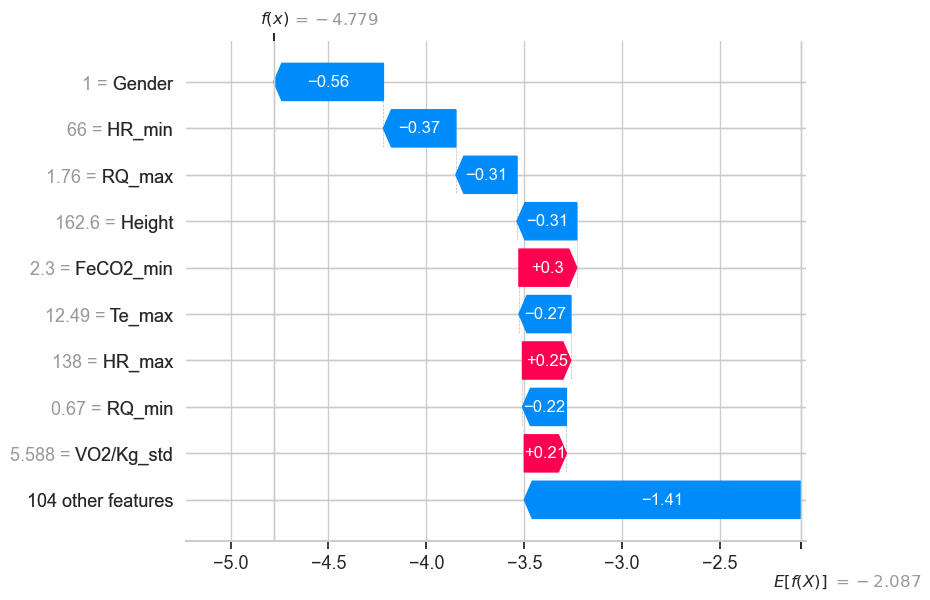

In [168]:
# Waterfall for the first patient
shap.plots.waterfall(shap_values[0])

In [169]:
shap.plots.initjs()

In [170]:
# Forceplot for the first patient
shap.plots.force(shap_values[0])
# Forceplot for the first 100 patients
#shap.plots.force(shap_values[0:100])

In [171]:
# Mean SHAP value
shap_values_df = pd.DataFrame({"feature_names": shap_values.feature_names, "values": np.mean(np.abs(shap_values.values), axis=0)}).sort_values(by="values", ascending=False)

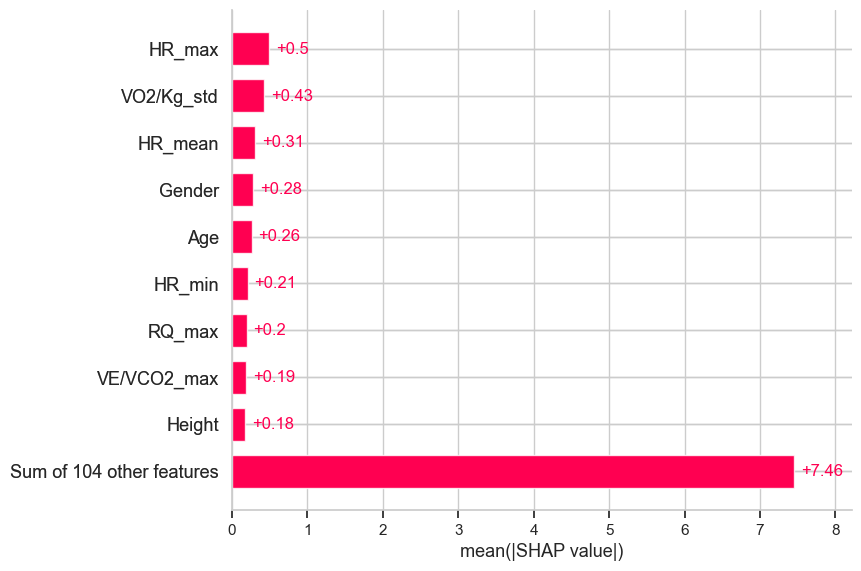

In [172]:
# Mean SHAP value for feature importance
shap.plots.bar(shap_values, max_display=10)

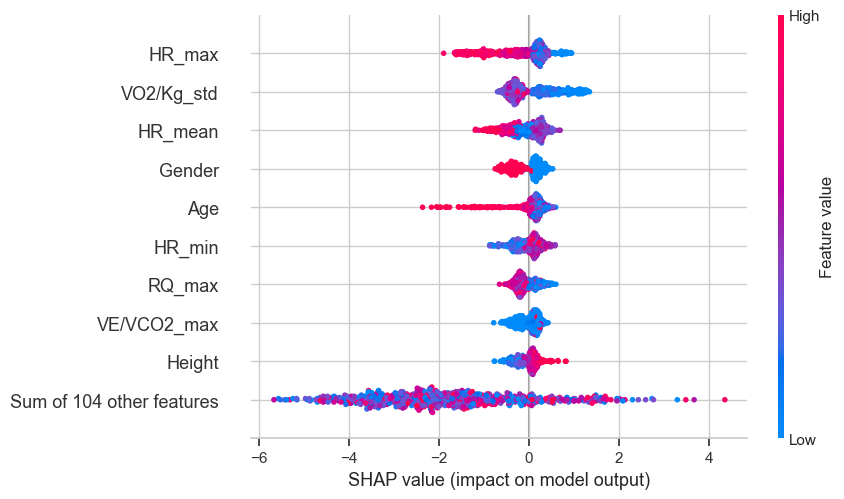

In [173]:
# Beeswarm plot for feature importance
shap.plots.beeswarm(shap_values, max_display=10)

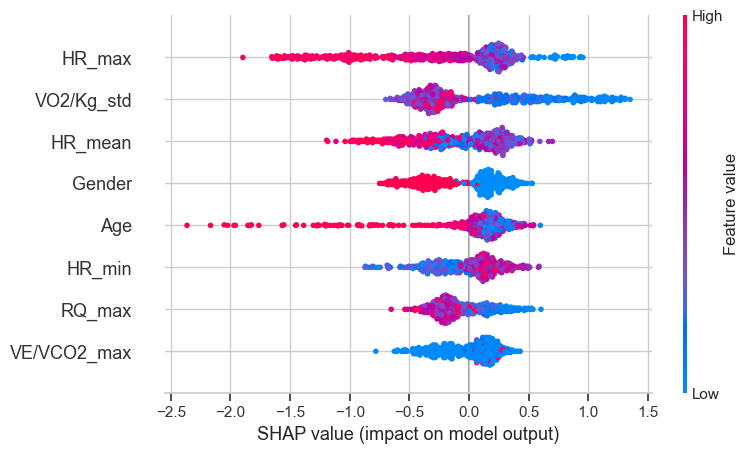

In [195]:
# Summary plot
shap.summary_plot(shap_values, x_test, max_display=8)

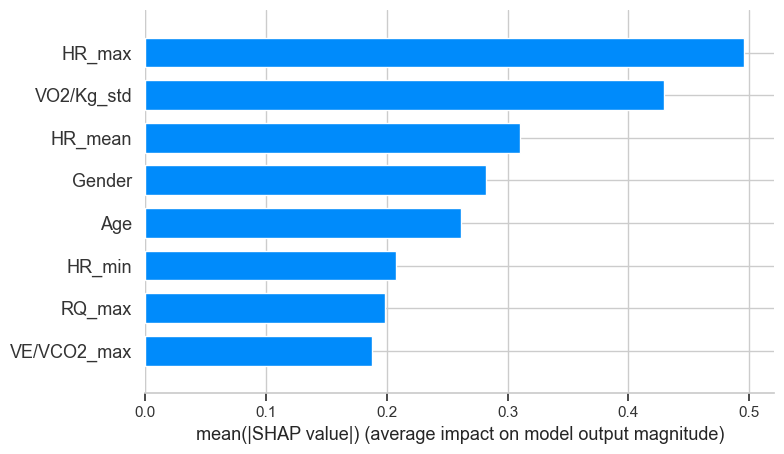

In [196]:
# Summary plot
shap.summary_plot(shap_values, x_test, max_display=8, plot_type='bar')

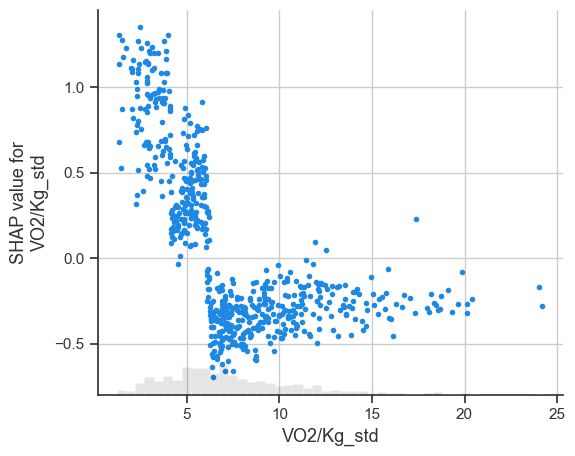

In [176]:
# Dependence plot
shap.plots.scatter(shap_values[:, "VO2/Kg_std"])

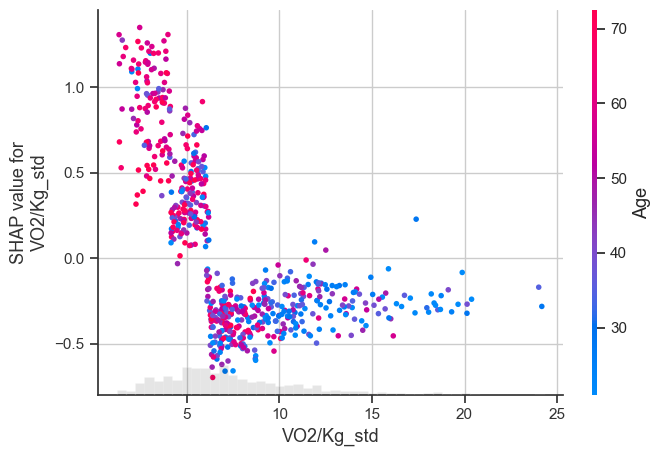

In [177]:
# Dependence plot
shap.plots.scatter(shap_values[:, "VO2/Kg_std"], color=shap_values[:, "Age"])

#### Prediction

In [197]:
# Predicted probablity
y_prob = model.predict_proba(x_test)[:,1] # Probabilities for the positive class

**Youden's index**

In [198]:
# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Youden's Index for each threshold
youden_index = tpr - fpr

# Find the optimal threshold (the one that maximizes Youden's Index)
optimal_threshold_index = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_threshold_index]

print(f'Optimal Cut-off Threshold using Youden\'s Index: {optimal_threshold:.4f}')

Optimal Cut-off Threshold using Youden's Index: 0.0526


**Predicted outcome**

In [199]:
# Predicted outcome
# y_pred = (y_prob >= optimal_threshold).astype(int)
y_pred = model.predict(x_test)

In [200]:
# Group by predicted outcome and summarize the distribution of 'Death'
x_test_result = x_test.copy()
x_test_result['y_pred'] = y_pred
x_test_result['Death'] = data.loc[x_test_result.index, 'Death']
x_test_result['composite_outcome'] = data.loc[x_test_result.index, 'composite_outcome']

In [201]:
x_test_result.groupby('y_pred')['Death'].value_counts().unstack(fill_value=0)

Death   0.0  1.0
y_pred          
0       561    9
1        49    6

In [202]:
x_test_result.groupby('composite_outcome')['Death'].value_counts().unstack(fill_value=0)

Death              0.0  1.0
composite_outcome          
0.0                525    7
1.0                 85    8

#### Model performance

**Confusion matrix**

In [203]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[506,  26],
       [ 64,  29]])

In [204]:
tn, fp, fn, tp = conf_mat.ravel()

# Precision (Positive Predictive Value)
precision = tp / (tp + fp)

# Recall (Sensitivity)
recall = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# Sensitivity (same as recall)
sensitivity = recall

# Negative Predictive Value (NPV)
npv = tn / (tn + fn)

# Positive Predictive Value (PPV)
ppv = precision  # Same as precision

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

# Printing all the metrics
print(f'Precision (PPV): {precision:.3f}')
print(f'Recall (Sensitivity): {recall:.3f}')
print(f'Specificity: {specificity:.3f}')
print(f'Sensitivity: {sensitivity:.3f}')
print(f'Negative Predictive Value (NPV): {npv:.3f}')
print(f'Positive Predictive Value (PPV): {ppv:.3f}')
print(f'Accuracy: {accuracy:.3f}')
print(f'F1 Score: {f1:.3f}')

Precision (PPV): 0.527
Recall (Sensitivity): 0.312
Specificity: 0.951
Sensitivity: 0.312
Negative Predictive Value (NPV): 0.888
Positive Predictive Value (PPV): 0.527
Accuracy: 0.856
F1 Score: 0.392


In [205]:
def confusion_plot(matrix, labels=None):
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
    
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.heatmap(data=matrix, cmap='Blues', annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=ax, cbar=False)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')

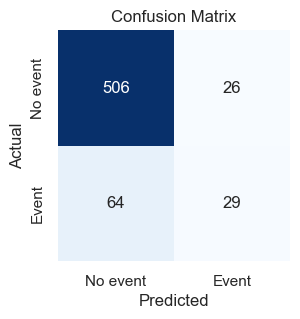

In [206]:
confusion_plot(conf_mat, labels=['No event', 'Event'])

**AUC value & ROC curve**

In [207]:
def calc_roc_curve(
    y_true: np.ndarray,
    y_prob: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:

    # Define thresholds: 1000 equally spaced values between 0 and 1
    thresholds = np.linspace(0, 1, 1000)
    
    # Initialize arrays for FPR and TPR
    fprs = []
    tprs = []
    
    # Loop over each threshold and calculate FPR and TPR
    for threshold in thresholds:
        # Predicted positive based on threshold
        predicted_positive = (y_prob >= threshold).astype(int)
        
        # Calculate True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN)
        tp = np.sum((predicted_positive == 1) & (y_true == 1))
        fp = np.sum((predicted_positive == 1) & (y_true == 0))
        fn = np.sum((predicted_positive == 0) & (y_true == 1))
        tn = np.sum((predicted_positive == 0) & (y_true == 0))
        
        # Calculate TPR and FPR
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity or recall
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # 1 - Specificity
        
        # Append the calculated rates
        tprs.append(tpr)
        fprs.append(fpr)

    fprs = np.array(fprs)
    tprs = np.array(tprs)
    
    return fprs, tprs

In [208]:
def display_roc_curve(
    fpr_tpr_list: List[Tuple[np.ndarray, np.ndarray]],
    model_name_list: List[str],
    filename: Union[str, None] = None,
):
    # Plot the ROC curve using seaborn
    sns.set()
    plt.figure()
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 6))

    # Plot each ROC curve
    for (fpr, tpr), model_name in zip(fpr_tpr_list, model_name_list):
        plt.plot(fpr, tpr, label=model_name, linewidth=2)
    
    # Add the diagonal line for random performance
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Performance')

    # Set axis labels and title
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

    # Add legend
    plt.legend(fontsize=12, loc='lower right')

    # Adjust layout and save the plot if a filename is provided
    plt.tight_layout()
    if filename:
        plt.savefig(filename, format='png')

    # Show the plot
    plt.show()

<Figure size 640x480 with 0 Axes>

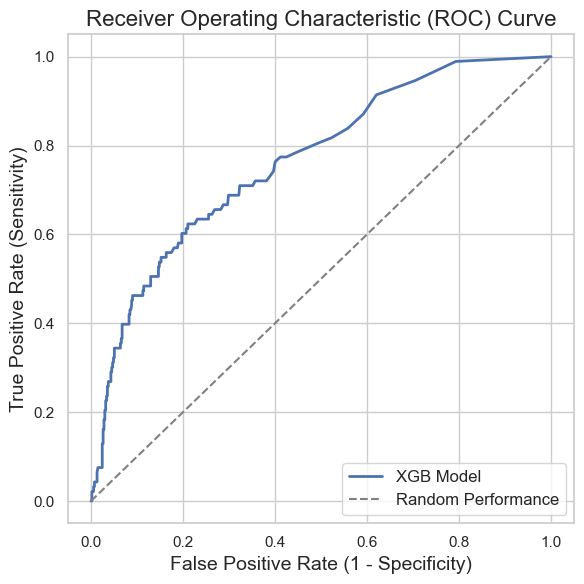

In [209]:
fpr, tpr = calc_roc_curve(y_test, y_prob)
display_roc_curve([(fpr, tpr)],["XGB Model"])

In [210]:
# Bootstrap function for calculating confidence intervals of AUC
def bootstrap_auc(y_true, y_prob, n_iterations=1000, random_state=None):
    auc_scores = []

    for _ in range(n_iterations):
        X_resample, y_resample = resample(y_prob, y_true, n_samples=len(y_true), random_state=random_state)
        auc_scores.append(roc_auc_score(y_resample, X_resample))
        
    auc_lower = np.percentile(auc_scores, 2.5)
    auc_upper = np.percentile(auc_scores, 97.5)
    
    # Return the mean values of C-index and AUC, along with their confidence intervals
    return auc_lower, auc_upper

In [211]:
# Bootstrap to calculate C-index, AUC and their 95% CI
auroc = auc(fpr, tpr)
auc_lower, auc_upper = bootstrap_auc(y_test, y_prob)
print(f"AUC: {auroc:.3f} (95% CI: {auc_lower:.3f} - {auc_upper:.3f})")

AUC: 0.766 (95% CI: 0.712 - 0.818)


**Calibration Curve**

In [192]:
def display_calibration_plot(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    filename: Union[str, None] = None,
):
    # Compute the calibration curve
    prob_true, prob_pred = calibration_curve(
        y_true, y_prob, n_bins=10, strategy='uniform'
    )
    
    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    
    # Add labels and title
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot')
    plt.legend()
    
    # Save the plot if a filename is provided
    if filename:
        plt.savefig(filename, format='png')
    
    # Show the plot
    plt.show()

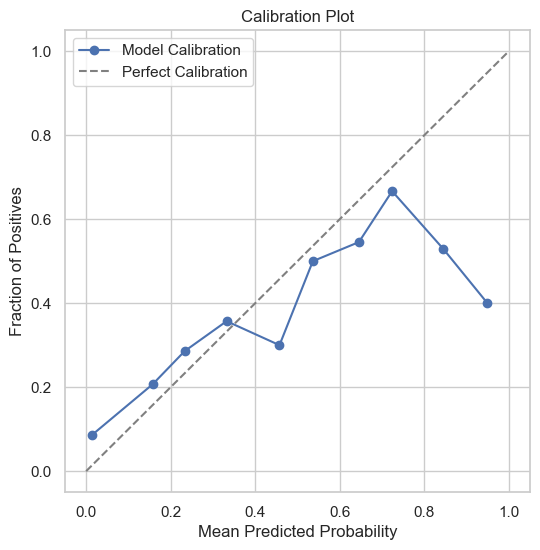

In [193]:
display_calibration_plot(y_test, y_prob)

In [213]:
data.shape

(2081, 115)